# How little data do we need to fit a sine wave?


So really how little data do we need to fit a sine wave? Or alternatively how does our frequency determination improve with various forms of extra data.

The dimension we will explore are:
1. Sampling rate (in number of samples per period)
2. Sampling length (in number of periods sampled)
3. SNR in dB on signal above noise**

** we can define the noise power and the signal power as mean squared value
$$ 
P = \frac{1}{N} \sum_{i=0}^{N-1} (y_i)**2 $$
where $y_i$ are the individual samples of pure noise or signal. We will model the noise using a normal distribution with a mean of 0 and width of $\sigma$ so $P_{noise}=\sigma^2$ 


Meanwhile for a sine wave defined as $y = A \sin (wt + \phi)$ the power in the signal is $P_{signal}=\frac{A^2}{2}$


In [1]:
# Import some standard python analysis and plotting packages
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib
import math

In [2]:
def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

In [3]:
#Now let's get some numbers between 0 and 1
t=np.linspace(0,1,100)

# Then if we set the angular frequency to  2pi we will have 1 full period before 0 and 1
yclean=getSine(t,2*math.pi,1,0)


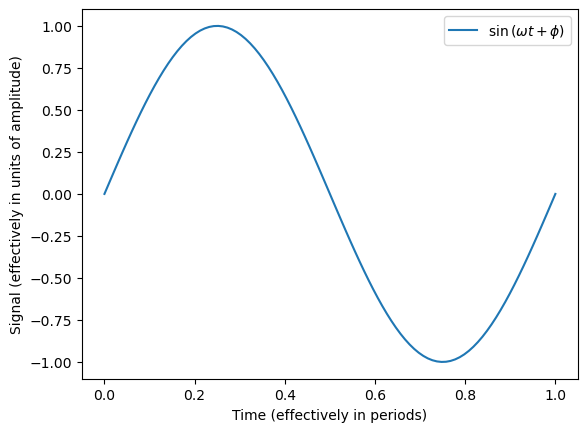

In [4]:
#Now let's plot our sine wave
fig,ax = plt.subplots()
ax.plot(t,getSine(t,2*math.pi,1,0),label=r"$\sin \left( \omega t + \phi \right)$")
ax.set_xlabel("Time (effectively in periods)")
ax.set_ylabel("Signal (effectively in units of amplitude)")
ax.legend()

## Curve fitting
Now we are going to try and do some curve fitting to this 1 period piece of data and see how well we can determine the frequency

We will do this test using the curve_fit function from scipy's optimize library

With infinte SNR how well can we determine the frequency of a sine wave using a single period of data??

In [5]:
# Import the curve_fit function
from scipy.optimize import curve_fit

# Actually do the fit to the clean data
parameters, covariance = curve_fit(getSine, t, yclean)

In [6]:
print("parameters",parameters)
print("covariance",covariance)
print("frequency error",1-(parameters[0]/(2*math.pi)))
print("error on frequency from fit",np.sqrt(covariance[0][0]))


parameters [ 6.28318531e+00  1.00000000e+00 -6.07755287e-09]
covariance [[ 4.61446704e-19  3.48221400e-20 -5.15581738e-20]
 [ 3.48221400e-20  1.13309837e-19 -3.44021867e-21]
 [-5.15581738e-20 -3.44021867e-21  1.83208630e-20]]
frequency error -1.215479272786979e-09
error on frequency from fit 6.792986857683686e-10


## Noiseless -- 5 parts in 10^10

So at infinite SNR we can determine the frequency to better than 5 parts in $10^10$ using just a single period of data

In [7]:
parameters, covariance = curve_fit(getSine, t, yclean+np.random.normal(0,1e-9,size=yclean.size))

In [8]:
print(parameters)

[6.28318529e+00 1.00000000e+00 3.28801101e-09]


In [9]:
noise=np.random.normal(0,1,size=yclean.size)
print("Mean squared power in sine wave:",np.mean(yclean**2))
print("Mean squared power in noise:",np.mean(noise**2))

def getSNRdB(signal,noise):
    Ps=np.mean(signal**2)
    Pn=np.mean(noise**2)
    return 10*math.log10(Ps/Pn)

print("SNR in dB:",getSNRdB(yclean,noise))
print("SNR in dB:",getSNRdB(yclean,np.random.normal(0,0.05,size=yclean.size)))


Mean squared power in sine wave: 0.495
Mean squared power in noise: 0.9053652439323523
SNR in dB: -2.622186194141812
SNR in dB: 23.81240726815422


In [10]:
#numThrows=1000
#numSamplesPerPeriod=100   
trueOmega=2*math.pi
trueAmp=1
truePhase=0


def doMonteCarloPoint(numThrows,numSamplesPerPeriod,noiseSigma,numPeriods):

    snrs=np.zeros(numThrows)
    omegas=np.zeros(numThrows)
    amps=np.zeros(numThrows)
    phases=np.zeros(numThrows)


    t=np.linspace(0,numPeriods,numPeriods*numSamplesPerPeriod)
    signal=getSine(t,trueOmega,trueAmp,truePhase)

    #noiseSigma=0.1

    for i in range(numThrows):
        noise=np.random.normal(0,noiseSigma,size=signal.size)
        snrs[i]=getSNRdB(signal,noise)
        parameters, covariance = curve_fit(getSine, t, signal+noise,p0=[trueOmega,trueAmp,truePhase])
        omegas[i]=parameters[0]
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    
    return snrs,omegas,amps,phases
    

0.048715398807725234
16.97841771565359


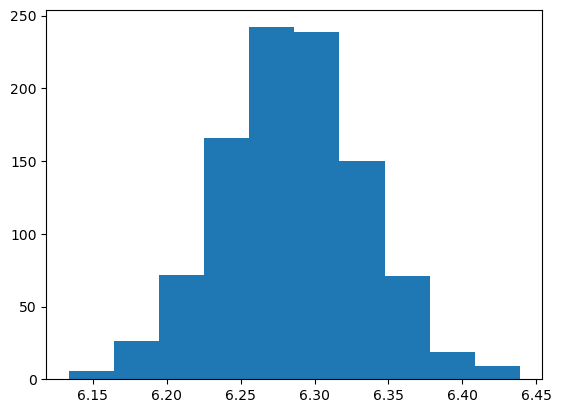

In [11]:
snrs,omegas,amps,phases=doMonteCarloPoint(1000,100,0.1,1)
fig,ax = plt.subplots()
ax.hist(omegas)
print(np.std(omegas))
print(np.mean(snrs))

In [12]:
def getOmegaSnr(numThrows,numSampsArray,noise,numPeriods):
    #numSampsArray=np.logspace(1,4,10)
    omegaStd=[]
    snrMean=[]
    for val in numSampsArray:
        numSamps=int(val)
        snrs,omegas,amps,phases=doMonteCarloPoint(numThrows,numSamps,noise,numPeriods)
        omegaStd.append(np.std(omegas))
        snrMean.append(np.mean(snrs))
    omegaStd=np.array(omegaStd)
    snrMean=np.array(snrMean)
    return omegaStd,snrMean

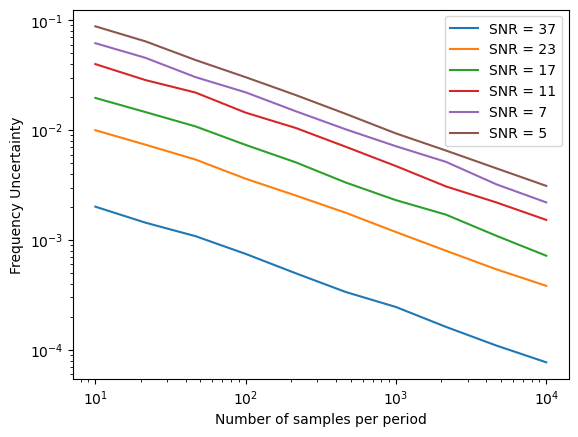

In [13]:
fig,ax = plt.subplots()
numSampsArray=np.logspace(1,4,10)
for noise in [0.01,0.05,0.1,0.2,0.3,0.4]:
    omegaStd,snrMean=getOmegaSnr(1000,numSampsArray,noise,1)
    ax.plot(numSampsArray,omegaStd/trueOmega,label="SNR = "+str(round(np.mean(snrMean))))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples per period")
ax.set_ylabel("Frequency Uncertainty")
ax.legend()

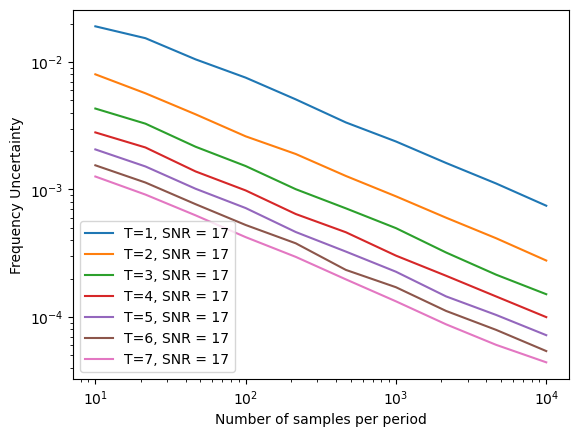

In [24]:
fig,ax = plt.subplots()
numSampsArray=np.logspace(1,4,10)
noise=0.1

omegaArray=[]

for period in range(1,8):
    omegaStd,snrMean=getOmegaSnr(1000,numSampsArray,noise,period)
    omegaArray.append(omegaStd/trueOmega)
    ax.plot(numSampsArray,omegaStd/trueOmega,label="T="+str(period)+", SNR = "+str(round(np.mean(snrMean))))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples per period")
ax.set_ylabel("Frequency Uncertainty")
ax.legend()

In [15]:
omegaArray=np.array(omegaArray)
print(np.shape(omegaArray))


(7, 10)


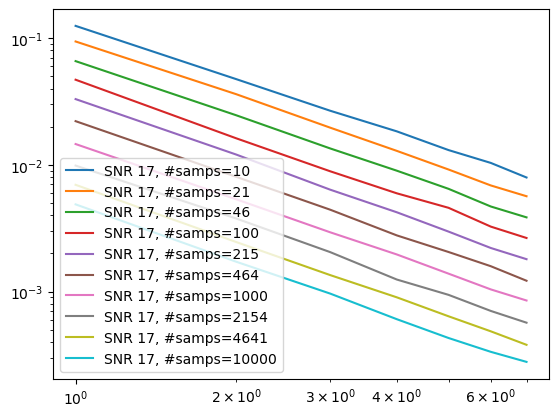

In [16]:
fig,ax = plt.subplots()
for i in range(10):
    ax.plot(range(1,8),omegaArray.T[i],label="SNR 17, #samps="+str(int(numSampsArray[i])))
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

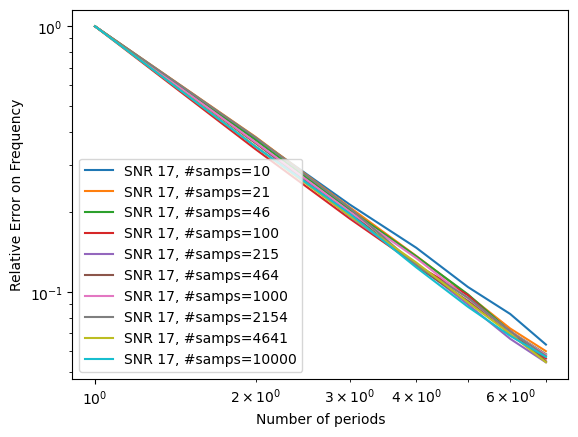

In [17]:
fig,ax = plt.subplots()
for i in range(10):
    ax.plot(range(1,8),omegaArray.T[i]/omegaArray.T[i][0],label="SNR 17, #samps="+str(int(numSampsArray[i])))
ax.legend()
ax.set_xlabel("Number of periods")
ax.set_ylabel("Relative Error on Frequency")
ax.set_yscale('log')
ax.set_xscale('log')

In [18]:
print(1./np.mean(omegaArray/omegaArray[0,:],axis=1))
print(np.mean(omegaArray/omegaArray[0,:],axis=1))

[ 1.          2.72820349  4.97505435  7.6068392  10.51644605 13.96974982
 17.37413498]
[1.         0.36654157 0.20100283 0.13146065 0.09508916 0.07158324
 0.05755682]


0.07692307692307693

In [20]:
numbers=np.arange(1,8)
print(numbers)

[1 2 3 4 5 6 7]


In [21]:
print(np.mean(omegaArray/omegaArray[0,:],axis=1)*((numbers)**1.5))

[1.         1.03673613 1.04444134 1.05168517 1.06312911 1.05205452
 1.06596727]


In [22]:
print(np.log(np.mean(omegaArray/omegaArray[0,:],axis=1))/np.log(numbers))

[        nan -1.44795125 -1.46042085 -1.46364855 -1.46196402 -1.47167871
 -1.46717083]


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_51017/1212076121.py:1: RuntimeWarning: invalid value encountered in divide
  print(np.log(np.mean(omegaArray/omegaArray[0,:],axis=1))/np.log(numbers))


In [23]:
print(1/((numbers)**1.5))

[1.         0.35355339 0.19245009 0.125      0.08944272 0.06804138
 0.05399492]


(7, 10)


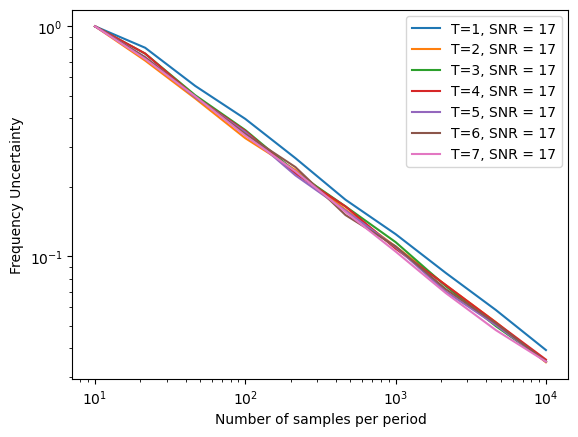

In [28]:
fig,ax = plt.subplots()
print(np.shape(omegaArray))
for i in range(1,8):
    ax.plot(numSampsArray,omegaArray[i-1]/omegaArray[i-1][0],label="T="+str(i)+", SNR = "+str(round(np.mean(snrMean))))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples per period")
ax.set_ylabel("Frequency Uncertainty")
ax.legend()

In [44]:
omegaArray=np.array(omegaArray)
flipScaleOmegaArray=np.transpose(omegaArray.T/omegaArray.T[0,:])
print(flipScaleOmegaArray)
print(1./np.mean(flipScaleOmegaArray,axis=0))
print(np.mean(flipScaleOmegaArray[1:],axis=0))
print(np.log(np.mean(flipScaleOmegaArray[1:],axis=0))/np.log(numSampsArray))

[[1.         0.80699372 0.55059116 0.39570724 0.26716372 0.17612122
  0.12482779 0.0846833  0.0584212  0.03910919]
 [1.         0.70975553 0.48559981 0.32617313 0.23704049 0.15938063
  0.110304   0.07498617 0.05171345 0.03458601]
 [1.         0.76099186 0.50162311 0.35385346 0.23288357 0.1647807
  0.11522883 0.07420629 0.04969006 0.0349224 ]
 [1.         0.76165605 0.4941379  0.35052236 0.22888009 0.16467241
  0.10791618 0.07502525 0.05160212 0.03553315]
 [1.         0.73493821 0.49139331 0.34668007 0.22480807 0.15790397
  0.10970783 0.07026048 0.05025268 0.03486545]
 [1.         0.73234652 0.49542018 0.34011422 0.24427078 0.15108038
  0.11046801 0.07198958 0.05111097 0.03485956]
 [1.         0.72135929 0.49586987 0.33444377 0.23408802 0.15594199
  0.10484748 0.06921564 0.04775194 0.03483274]]
[ 1.          1.3389336   1.99167177  2.860068    4.19378965  6.19534099
  8.93654902 13.45205165 19.41519095 28.14539963]
[1.         0.73684124 0.49400736 0.3419645  0.23366184 0.15896001
 0.10